In [1]:
import pandas as pd
from xgboost.sklearn import XGBClassifier
import xgboost
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt  

## 数据加载

In [2]:
train = pd.read_csv('./data/train.csv', header=0)
test = pd.read_csv('./data/test.csv', header=0)

In [3]:
# 训练集和测试集合并，处理特征
data = train.append(test,sort=False)

## 特征处理

性别映射为数值

In [4]:
labelEncode = LabelEncoder()
data['Sex'] = labelEncode.fit_transform(data['Sex'])

构建新特征family表示是否有亲人一同出行：0表示独自出行，1表示有家人陪同

In [5]:
data['Family'] = data['SibSp'] + data['Parch']
data.loc[data['Family'] > 0,'Family']= 1

对年龄缺失值用中位数填充

In [6]:
data['Age'] = data['Age'].fillna(data['Age'].median())

In [7]:
data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family
0,1,0.0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,0
5,6,0.0,3,"Moran, Mr. James",1,28.0,0,0,330877,8.4583,NaN,Q,0
6,7,0.0,1,"McCarthy, Mr. Timothy J",1,54.0,0,0,17463,51.8625,E46,S,0
7,8,0.0,3,"Palsson, Master. Gosta Leonard",1,2.0,3,1,349909,21.0750,NaN,S,1
8,9,1.0,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.0,0,2,347742,11.1333,NaN,S,1
9,10,1.0,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.0,1,0,237736,30.0708,NaN,C,1


## 模型训练

划分数据

In [8]:
trainX = data[0:train.shape[0]][['Pclass','Sex','Age','Fare','Family']]
testX = data[train.shape[0]::][['Pclass','Sex','Age','Fare','Family']]
trainY = data[0:train.shape[0]]['Survived']

训练xgboost模型

In [9]:
params = {
    'learning_rate':[0.10,0.15,0.20,0.25,0.30],
    'max_depth':[3,4,5,6,7,8],
    'gamma':[ 0.2,  0.4, 0.6]
}

In [10]:
xgb = XGBClassifier(n_estimators = 100,subsample = 0.8,colsample_bytree=0.8,seed=1234)
clf = GridSearchCV(xgb, params,scoring='roc_auc')
clf.fit(trainX,trainY)

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1234,
       silent=True, subsample=0.8),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1, 0.15, 0.2, 0.25, 0.3], 'max_depth': [3, 4, 5, 6, 7, 8], 'gamma': [0.2, 0.4, 0.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [11]:
bst = clf.best_estimator_ 

In [12]:
clf.best_params_

{'gamma': 0.4, 'learning_rate': 0.15, 'max_depth': 3}

In [13]:
predictions = bst.predict(testX)

/disk1/exec/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [14]:
submission = pd.DataFrame({ 'PassengerId': test['PassengerId'],'Survived': predictions.astype(int) })
submission.to_csv("submission-xgboost-cv.csv", index=False)

In [15]:
bst.feature_importances_

array([0.0867347 , 0.05612245, 0.32993197, 0.5017007 , 0.0255102 ],
      dtype=float32)

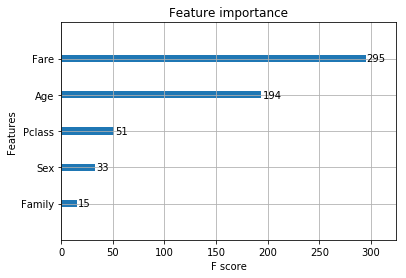

In [16]:
xgboost.plot_importance(bst._Booster)

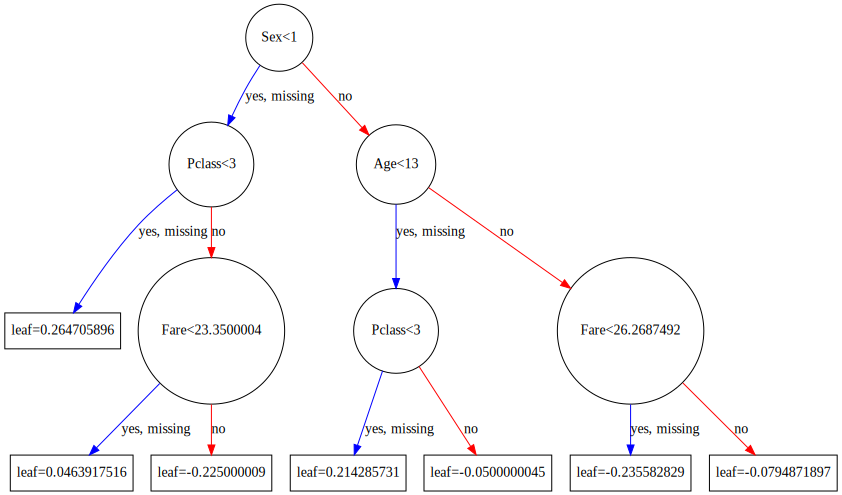

In [20]:
xgboost.to_graphviz(bst._Booster,num_trees = 0)

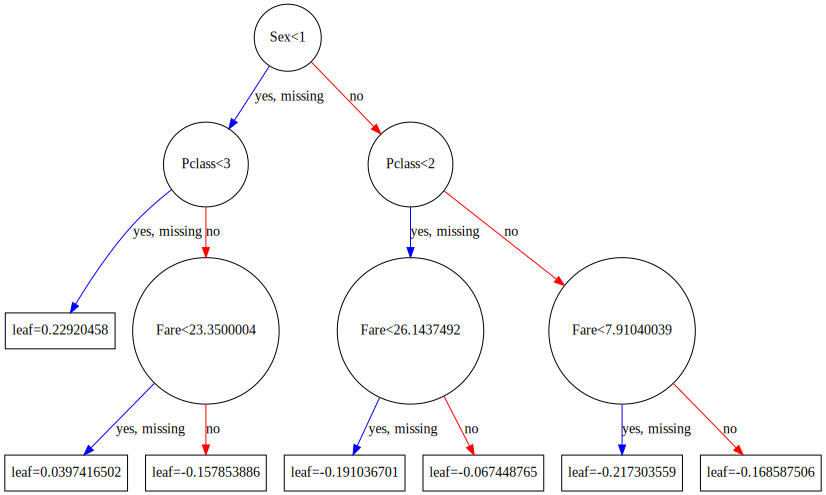

In [21]:
xgboost.to_graphviz(bst._Booster,num_trees = 1)